# Introduction

In this quick endeavor, I want to return to the idea I had about using backpropogation on a classifier as a means for generation. I tried this on networks trained on ImageNet earlier (in a notebook called doggiestdog.ipynb), though the gradients lacked human significance, and the experiment ultimately turned into exercises with adversarial examples. 

I had the thought that since those networks had seen so many different kinds of images, they could be more inclined to make changes in various directions, where as a simpler classifier might make fewer adjustments. MNIST digits are pretty basic, and most of the non-zero pixels are in the same area, so maybe this backprop generation method could work better. 

My instinct tells me that it won't though. Let's find out!

In [0]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.ToTensor()), 
                       batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.ToTensor()), 
                       batch_size=batch_size, shuffle=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# Classifiers

Let's train some classifiers. I'm pretty sure we'll only need fully connected layers, but just for kicks, we'll make another one with convolutional layers.

In [0]:
class FC(nn.Module):
  def __init__(self, num_classes=10):
    super(FC, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32,num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, input):
    return self.main(input.view(-1, 784))


In [4]:
simple = FC().to(device)
print(simple)

FC(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)


In [131]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1,4,4,2,1), # size: 4 x 14 x 14
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.Conv2d(4,8,4,2,1), # size: 8 x 7 x 7 
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(8,16,4,1,0), # size: 16 x 4 x 4,
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16,num_classes,4,1,0), # size: num_classes x 1 x 1
        nn.BatchNorm2d(num_classes),
        nn.Sigmoid()
    )

  def forward(self, input):
    # I know my squeeze's are kind of hacky, but I can't do squeeze()
    # because when I train_to_target, I want to keep my batchsize of 1
    return self.main(input).squeeze(-1).squeeze(-1) 

cnn = ConvNet().to(device)
print(cnn)

ConvNet(
  (main): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(16, 10, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)


# Training

boiler plate training code

edit: added parameter to train with extra garbage class

In [0]:
def train(model, epochs=5, lr=0.001, with_garbage=False):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(epochs):
      msg = 'Epoch: {}.......'.format(epoch+1)
      for phase in ['train', 'val']:
          if phase == 'val':
              model.eval()
              loader = test_loader
          else:
              model.train()
              loader = train_loader
          
          running_loss = 0
          correct = 0
          total = 0
          for inputs, labels in loader:
              if with_garbage:
                  extra_len = inputs.size(0) // 10 + 1
                  extra_samples = torch.randn((extra_len,1,28,28))
                  extra_labels = torch.LongTensor([10]*extra_len)
                  inputs = torch.cat((inputs, extra_samples), dim=0)
                  labels = torch.cat((labels, extra_labels), dim=0)

              inputs = inputs.to(device)
              labels = labels.to(device)
              
              optimizer.zero_grad()
              outputs = model(inputs)
              _, preds = torch.max(outputs, dim=1)
              correct += torch.sum(preds == labels)
              total += inputs.size(0)
              loss = criterion(outputs, labels)
              
              if phase == 'train':
                  loss.backward()
                  optimizer.step()
              running_loss += loss.item()
          # print(correct / loader.dataset.size(), len(loader.dataset))
          # print('{}'.format(correct))

          msg += '{} Loss: {:.3f}.......{} Acc: {:.3f}.......'\
          .format(phase, running_loss / total, phase, correct.float() / total)

      print(msg)
      

  return model

In [55]:
simple_trained = train(simple)

Epoch: 1.......train Loss: 0.012.......train Acc: 0.973.......val Loss: 0.012.......val Acc: 0.971.......
Epoch: 2.......train Loss: 0.012.......train Acc: 0.977.......val Loss: 0.012.......val Acc: 0.970.......
Epoch: 3.......train Loss: 0.012.......train Acc: 0.980.......val Loss: 0.012.......val Acc: 0.972.......
Epoch: 4.......train Loss: 0.012.......train Acc: 0.980.......val Loss: 0.012.......val Acc: 0.970.......
Epoch: 5.......train Loss: 0.012.......train Acc: 0.985.......val Loss: 0.012.......val Acc: 0.975.......


As expected, the neural net does really well on this classsification task. It would have been better practice to save the weights that yielded the highest validation accuracy, but whatever. 

# Backprop generation

In [0]:
def imshow(tens):
  unloader = transforms.ToPILImage()
  img = unloader(tens.cpu().squeeze(0))
  plt.imshow(img)
  plt.show()

def train_to_target(model, target_ind=0, penalty_weight=1e3):
  input_img = torch.zeros((1,1,28,28)).to(device)
  og_input = input_img.clone()
  optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
  criterion = nn.CrossEntropyLoss()
  target = torch.LongTensor([target_ind]).to(device)
  model.eval()

  prob = [0]
  iteration = [0]
  max_iterations = 200
  img_hist = []
  while prob[0] < 0.99 and iteration[0] < max_iterations:

      def closure():
          # correct the values of updated input image
          input_img.data.clamp_(0, 1)
          optimizer.zero_grad()
          out = model(input_img)
          loss1 = criterion(out, target.detach())
          penalty = F.mse_loss(input_img, og_input)
          loss = penalty_weight*penalty + loss1
          loss.backward()

          # let's figure out what probability our network thinks the current image
          # belongs to the target class
          probs = F.softmax(out, dim=1)
          prob[0] = probs[0][target_ind]

          iteration[0] += 1
          if iteration[0] % 20 == 0 or prob[0] > 0.99:
              print("iteration: {}.......P(in target class): {:.6f}.......Loss: {:.6f}" \
                .format(iteration[0], prob[0], loss.item()))
              img_hist.append(input_img)
              # imshow(input_img)
          return loss

      optimizer.step(closure)
  plt.figure(figsize=(20,5))
  hist = torch.stack(img_hist).detach()
  # some normalization so that we can see the changes
  print('Maximum pixel value: ', torch.max(hist))
  hist = torch.div(hist, torch.max(hist))
  plt.axis("off")
  plt.title('Modified Image over 200 Iterations (left to right)')
  plt.imshow(np.transpose(vutils.make_grid(hist.squeeze(1), padding=2, nrow=10).cpu(),(1,2,0)))
  plt.show()
  

# Experiments

## Part 1 - Simple Network

iteration: 20.......P(in target class): 0.218691.......Loss: 1.719233
iteration: 40.......P(in target class): 0.212739.......Loss: 1.707118
iteration: 60.......P(in target class): 0.214164.......Loss: 1.705114
iteration: 80.......P(in target class): 0.214038.......Loss: 1.704921
iteration: 100.......P(in target class): 0.214196.......Loss: 1.704856
iteration: 120.......P(in target class): 0.214028.......Loss: 1.704900
iteration: 140.......P(in target class): 0.214092.......Loss: 1.704890
iteration: 160.......P(in target class): 0.214134.......Loss: 1.704871
iteration: 180.......P(in target class): 0.214057.......Loss: 1.704884
iteration: 200.......P(in target class): 0.214061.......Loss: 1.704926
Maximum pixel value:  tensor(0.0696, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


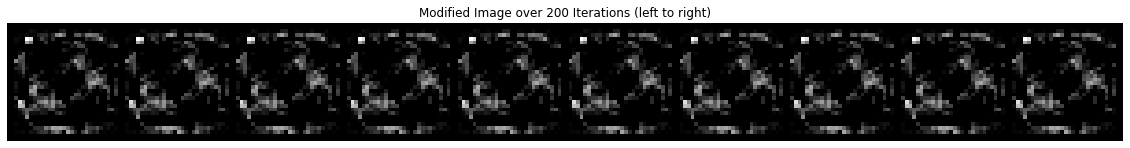

In [229]:
train_to_target(simple_trained, 0)

iteration: 20.......P(in target class): 0.220675.......Loss: 1.657581
iteration: 40.......P(in target class): 0.218214.......Loss: 1.643965
iteration: 60.......P(in target class): 0.219195.......Loss: 1.641113
iteration: 80.......P(in target class): 0.218792.......Loss: 1.640285
iteration: 100.......P(in target class): 0.218976.......Loss: 1.640351
iteration: 120.......P(in target class): 0.217410.......Loss: 1.645135
iteration: 140.......P(in target class): 0.218466.......Loss: 1.639911
iteration: 160.......P(in target class): 0.219081.......Loss: 1.640104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 180.......P(in target class): 0.218471.......Loss: 1.639415
iteration: 200.......P(in target class): 0.219580.......Loss: 1.639568
Maximum pixel value:  tensor(0.0591, device='cuda:0')


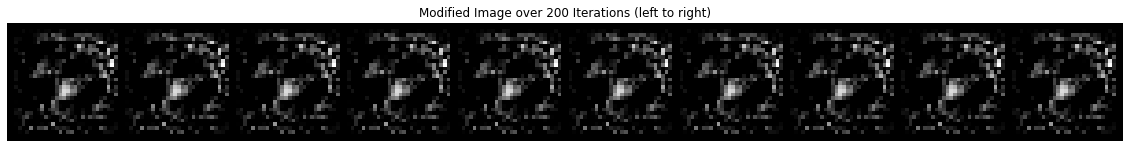

In [230]:
train_to_target(simple_trained, 8)

iteration: 20.......P(in target class): 0.215362.......Loss: 1.702582
iteration: 40.......P(in target class): 0.215121.......Loss: 1.692046
iteration: 60.......P(in target class): 0.215213.......Loss: 1.690610
iteration: 80.......P(in target class): 0.214697.......Loss: 1.690405
iteration: 100.......P(in target class): 0.214812.......Loss: 1.690323
iteration: 120.......P(in target class): 0.214900.......Loss: 1.690312
iteration: 140.......P(in target class): 0.214832.......Loss: 1.690332
iteration: 160.......P(in target class): 0.214780.......Loss: 1.690401
iteration: 180.......P(in target class): 0.214782.......Loss: 1.690340
iteration: 200.......P(in target class): 0.215055.......Loss: 1.690367
Maximum pixel value:  tensor(0.0590, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


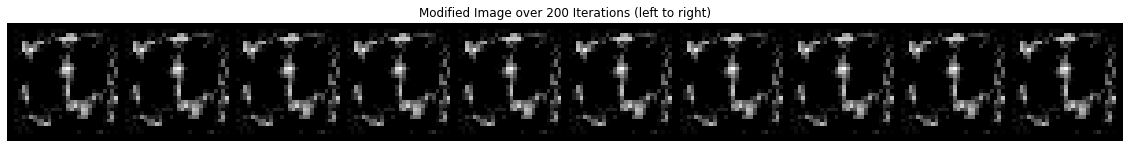

In [231]:
train_to_target(simple_trained, 1)

iteration: 20.......P(in target class): 0.228982.......Loss: 1.536280
iteration: 40.......P(in target class): 0.227807.......Loss: 1.524764
iteration: 60.......P(in target class): 0.228383.......Loss: 1.523453
iteration: 80.......P(in target class): 0.228384.......Loss: 1.523348
iteration: 100.......P(in target class): 0.228369.......Loss: 1.523311
iteration: 120.......P(in target class): 0.228509.......Loss: 1.523313
iteration: 140.......P(in target class): 0.228501.......Loss: 1.523243
iteration: 160.......P(in target class): 0.228360.......Loss: 1.523325
iteration: 180.......P(in target class): 0.228407.......Loss: 1.523308
iteration: 200.......P(in target class): 0.228497.......Loss: 1.523284
Maximum pixel value:  tensor(0.0482, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


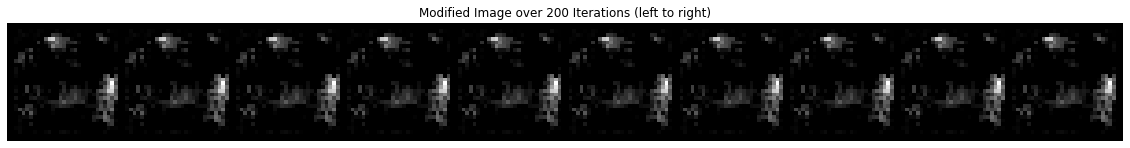

In [232]:
train_to_target(simple_trained, 2)

## Takeaways

The generated images have more real resemblance than in the previous experiments, but they still are no where as good as other generative methods (GAN, VAE). 

What is interesting to me is that the network still updated some of the pixels around the border of the image. I even added a penalty for altering the input image to reduce these changes, but the problem persisted to some degree. 

Before, I justified this behavior because the networks would need to take into account the entire image for images from ImageNet. I expected the network to only change pixels in the middle of the image for this MNIST classifier because MNIST digits are always against an empty (black) background. 

One idea is that networks will have unexpected behavior on expected input. Thus, it is very plausible that an image with a noisy foreground is still classified strongly in one class, as it will be classified in one class no matter what, so perhaps the right combination of noise could lead to a high activation on one node. As a potential remedy, I'm going to try training another classifier that includes a final class for 'garbage' inputs. With each batch, I'll concatenate a group of noise inputs with the class label 11.

One final observation is that the backprop method is far less effective in generating inputs that are very strongly classified by our simple MNIST classifier as the same method was for the more intricate ImageNet classifiers (see doggiestdog.ipynb). There, our generated inputs would quickly (roughly 10 iterations) exceed 99% in the probability that they belonged to the target class, where here we don't get past 25%. Maybe more intricate networks can backpropogate in a more nuanced way, which means that they can also be embarrassed more dramatically.

## Part 2 - Adding in Garbage Class

I've made a variation to our training code to allow for an eleventh garbage class. The hope is that this way, our backprop generation will be less likely to fill in outer pixels. However, we should note that digits with outer pixels filled in are still different than complete noise, so maybe this won't work. Let's see!

In [233]:
simple_with_garbage = FC(num_classes=11).to(device)
print(simple_with_garbage)

FC(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=11, bias=True)
    (7): Softmax(dim=1)
  )
)


In [234]:
trained_simple_with_garbage = train(simple_with_garbage, with_garbage=True)

Epoch: 1.......train Loss: 0.013.......train Acc: 0.734.......val Loss: 0.013.......val Acc: 0.783.......
Epoch: 2.......train Loss: 0.012.......train Acc: 0.789.......val Loss: 0.013.......val Acc: 0.790.......
Epoch: 3.......train Loss: 0.012.......train Acc: 0.797.......val Loss: 0.013.......val Acc: 0.796.......
Epoch: 4.......train Loss: 0.012.......train Acc: 0.804.......val Loss: 0.012.......val Acc: 0.872.......
Epoch: 5.......train Loss: 0.012.......train Acc: 0.883.......val Loss: 0.012.......val Acc: 0.886.......


Cool, it does pretty much just as well as before! It's nice that we didn't lose any accuracy by adding the garbage class. I imagine in adversarial training we would classify adversarial examples in this garbage class as well. 

Let's see how the performance of our backprop method changes.

iteration: 20.......P(in target class): 0.168837.......Loss: 2.076939
iteration: 40.......P(in target class): 0.170010.......Loss: 2.067677
iteration: 60.......P(in target class): 0.169130.......Loss: 2.066502
iteration: 80.......P(in target class): 0.169319.......Loss: 2.066284
iteration: 100.......P(in target class): 0.169094.......Loss: 2.066188
iteration: 120.......P(in target class): 0.169789.......Loss: 2.066450
iteration: 140.......P(in target class): 0.169306.......Loss: 2.066287
iteration: 160.......P(in target class): 0.169489.......Loss: 2.066291
iteration: 180.......P(in target class): 0.169467.......Loss: 2.066517
iteration: 200.......P(in target class): 0.169599.......Loss: 2.066560
Maximum pixel value:  tensor(0.0696, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


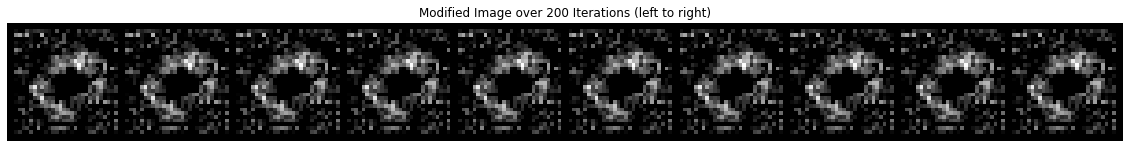

In [235]:
train_to_target(trained_simple_with_garbage, target_ind=0)

iteration: 20.......P(in target class): 0.156645.......Loss: 2.110257
iteration: 40.......P(in target class): 0.161067.......Loss: 2.101140
iteration: 60.......P(in target class): 0.160445.......Loss: 2.100264
iteration: 80.......P(in target class): 0.160507.......Loss: 2.100181
iteration: 100.......P(in target class): 0.160881.......Loss: 2.100387
iteration: 120.......P(in target class): 0.160755.......Loss: 2.100358
iteration: 140.......P(in target class): 0.160319.......Loss: 2.100754
iteration: 160.......P(in target class): 0.160372.......Loss: 2.101471
iteration: 180.......P(in target class): 0.160811.......Loss: 2.100470
iteration: 200.......P(in target class): 0.160107.......Loss: 2.101314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Maximum pixel value:  tensor(0.0780, device='cuda:0')


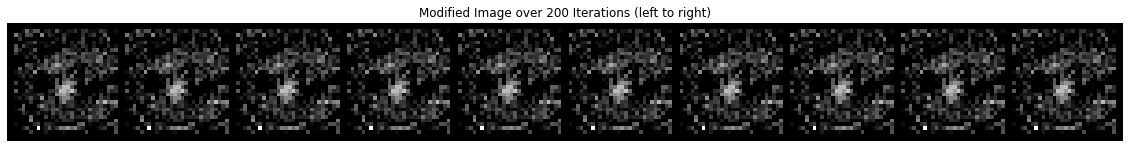

In [236]:
train_to_target(trained_simple_with_garbage, target_ind=8)

iteration: 20.......P(in target class): 0.166287.......Loss: 2.192711
iteration: 40.......P(in target class): 0.160800.......Loss: 2.160732
iteration: 60.......P(in target class): 0.164552.......Loss: 2.134090
iteration: 80.......P(in target class): 0.162889.......Loss: 2.128050
iteration: 100.......P(in target class): 0.161928.......Loss: 2.131093
iteration: 120.......P(in target class): 0.160994.......Loss: 2.135417
iteration: 140.......P(in target class): 0.164232.......Loss: 2.133538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 160.......P(in target class): 0.163310.......Loss: 2.134938
iteration: 180.......P(in target class): 0.162681.......Loss: 2.128623
iteration: 200.......P(in target class): 0.164766.......Loss: 2.128749
Maximum pixel value:  tensor(0.1118, device='cuda:0')


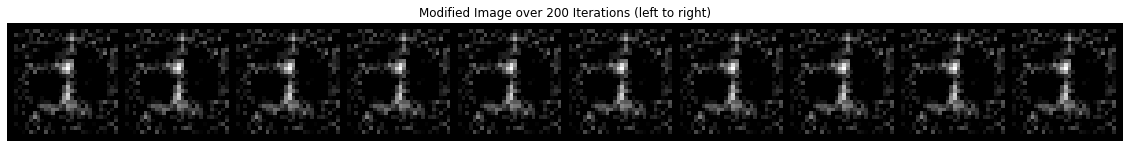

In [237]:
train_to_target(trained_simple_with_garbage, target_ind=1)

iteration: 20.......P(in target class): 0.186962.......Loss: 1.956177
iteration: 40.......P(in target class): 0.188794.......Loss: 1.938184
iteration: 60.......P(in target class): 0.186966.......Loss: 1.935561
iteration: 80.......P(in target class): 0.187193.......Loss: 1.935342
iteration: 100.......P(in target class): 0.187331.......Loss: 1.935425
iteration: 120.......P(in target class): 0.187031.......Loss: 1.935335
iteration: 140.......P(in target class): 0.187298.......Loss: 1.935483
iteration: 160.......P(in target class): 0.187186.......Loss: 1.935347
iteration: 180.......P(in target class): 0.187574.......Loss: 1.935497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 200.......P(in target class): 0.187163.......Loss: 1.935640
Maximum pixel value:  tensor(0.0689, device='cuda:0')


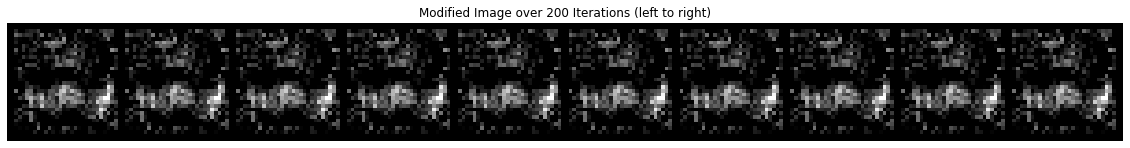

In [238]:
train_to_target(trained_simple_with_garbage, target_ind=2)

iteration: 20.......P(in target class): 0.187997.......Loss: 1.898011
iteration: 40.......P(in target class): 0.189042.......Loss: 1.887898
iteration: 60.......P(in target class): 0.187680.......Loss: 1.887421
iteration: 80.......P(in target class): 0.189137.......Loss: 1.886390
iteration: 100.......P(in target class): 0.189137.......Loss: 1.886567
iteration: 120.......P(in target class): 0.188049.......Loss: 1.886411
iteration: 140.......P(in target class): 0.188278.......Loss: 1.886582
iteration: 160.......P(in target class): 0.188441.......Loss: 1.887442
iteration: 180.......P(in target class): 0.190510.......Loss: 1.887899
iteration: 200.......P(in target class): 0.187543.......Loss: 1.887565
Maximum pixel value:  tensor(0.0695, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


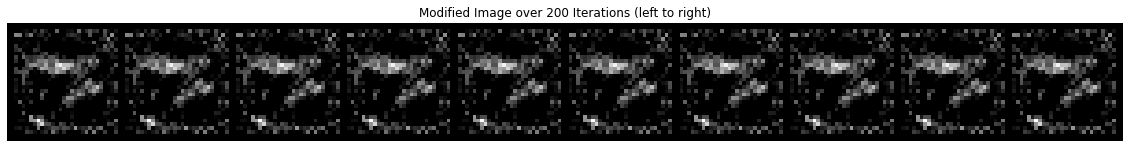

In [239]:
train_to_target(trained_simple_with_garbage, target_ind=7)

## Takeaways

In my opinion, it worked! Still not great, but definitely better than before. Might be worthwhile to have this sort of 'garbage class' for any classifier - it seems more intuitive to me. 

## Part 3 - CNNs

A CNN for MNIST classification really feels like overkill, but the goal here is to see how backprop through convolutional layers creates different kinds of gradients than backpropoagating through ordinary linear layers. In my VAE experiments, it was curious to see the CNN-based VAE performed worse than the VAE with linear layers. Let's see what happens here.

I added the code to the convolutional classifier above. I've printed the network below so you can take a peek at the architecture. Nothing crazy.

In [240]:
print(cnn)

ConvNet(
  (main): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(16, 10, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)


In [241]:
trained_cnn = train(cnn)

Epoch: 1.......train Loss: 0.012.......train Acc: 0.980.......val Loss: 0.012.......val Acc: 0.985.......
Epoch: 2.......train Loss: 0.012.......train Acc: 0.982.......val Loss: 0.012.......val Acc: 0.985.......
Epoch: 3.......train Loss: 0.012.......train Acc: 0.983.......val Loss: 0.012.......val Acc: 0.985.......
Epoch: 4.......train Loss: 0.012.......train Acc: 0.984.......val Loss: 0.012.......val Acc: 0.985.......
Epoch: 5.......train Loss: 0.012.......train Acc: 0.985.......val Loss: 0.012.......val Acc: 0.987.......


iteration: 20.......P(in target class): 0.184685.......Loss: 2.070185
iteration: 40.......P(in target class): 0.187963.......Loss: 2.043249
iteration: 60.......P(in target class): 0.188164.......Loss: 2.039858
iteration: 80.......P(in target class): 0.187516.......Loss: 2.041139
iteration: 100.......P(in target class): 0.188093.......Loss: 2.041281
iteration: 120.......P(in target class): 0.188397.......Loss: 2.041616
iteration: 140.......P(in target class): 0.188114.......Loss: 2.040175
iteration: 160.......P(in target class): 0.188475.......Loss: 2.043632
iteration: 180.......P(in target class): 0.188183.......Loss: 2.040425
iteration: 200.......P(in target class): 0.188006.......Loss: 2.039668
Maximum pixel value:  tensor(0.0817, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


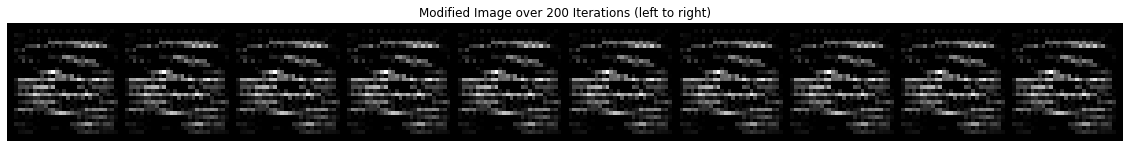

In [242]:
train_to_target(trained_cnn)

iteration: 20.......P(in target class): 0.219142.......Loss: 1.566269
iteration: 40.......P(in target class): 0.220039.......Loss: 1.564129
iteration: 60.......P(in target class): 0.219904.......Loss: 1.563889
iteration: 80.......P(in target class): 0.219917.......Loss: 1.563879
iteration: 100.......P(in target class): 0.220049.......Loss: 1.563842
iteration: 120.......P(in target class): 0.220002.......Loss: 1.563919
iteration: 140.......P(in target class): 0.219926.......Loss: 1.563908
iteration: 160.......P(in target class): 0.219979.......Loss: 1.563886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 180.......P(in target class): 0.219924.......Loss: 1.563934
iteration: 200.......P(in target class): 0.220047.......Loss: 1.563880
Maximum pixel value:  tensor(0.0316, device='cuda:0')


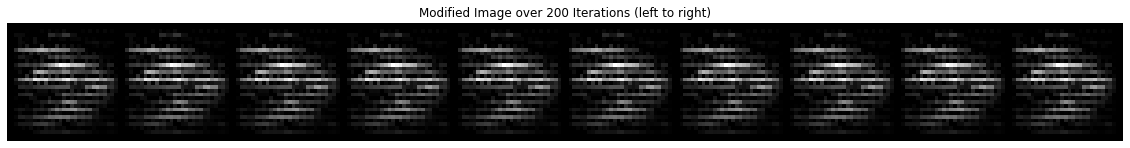

In [243]:
train_to_target(trained_cnn, 1)

iteration: 20.......P(in target class): 0.090690.......Loss: 2.497615
iteration: 40.......P(in target class): 0.090805.......Loss: 2.494042
iteration: 60.......P(in target class): 0.090734.......Loss: 2.493668
iteration: 80.......P(in target class): 0.090814.......Loss: 2.493713
iteration: 100.......P(in target class): 0.090811.......Loss: 2.493793
iteration: 120.......P(in target class): 0.090833.......Loss: 2.493615
iteration: 140.......P(in target class): 0.090792.......Loss: 2.493587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 160.......P(in target class): 0.090822.......Loss: 2.493795
iteration: 180.......P(in target class): 0.090768.......Loss: 2.493709
iteration: 200.......P(in target class): 0.090670.......Loss: 2.493879
Maximum pixel value:  tensor(0.0549, device='cuda:0')


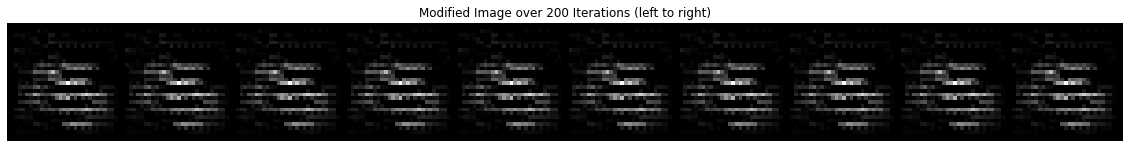

In [244]:
train_to_target(trained_cnn, 8)

## CNN with Garbage Class

In [245]:
cnn_with_garbage = ConvNet(11).to(device)
trained_cnn_with_garbage = train(cnn_with_garbage, with_garbage=True)

Epoch: 1.......train Loss: 0.014.......train Acc: 0.904.......val Loss: 0.013.......val Acc: 0.969.......
Epoch: 2.......train Loss: 0.013.......train Acc: 0.969.......val Loss: 0.012.......val Acc: 0.978.......
Epoch: 3.......train Loss: 0.012.......train Acc: 0.976.......val Loss: 0.012.......val Acc: 0.982.......
Epoch: 4.......train Loss: 0.012.......train Acc: 0.980.......val Loss: 0.012.......val Acc: 0.985.......
Epoch: 5.......train Loss: 0.012.......train Acc: 0.981.......val Loss: 0.012.......val Acc: 0.986.......


iteration: 20.......P(in target class): 0.117711.......Loss: 2.335696
iteration: 40.......P(in target class): 0.120585.......Loss: 2.329874
iteration: 60.......P(in target class): 0.119985.......Loss: 2.329677
iteration: 80.......P(in target class): 0.120258.......Loss: 2.330361
iteration: 100.......P(in target class): 0.120449.......Loss: 2.329701
iteration: 120.......P(in target class): 0.120204.......Loss: 2.329683
iteration: 140.......P(in target class): 0.120635.......Loss: 2.330840
iteration: 160.......P(in target class): 0.120428.......Loss: 2.329652
iteration: 180.......P(in target class): 0.120333.......Loss: 2.329881
iteration: 200.......P(in target class): 0.120378.......Loss: 2.328388
Maximum pixel value:  tensor(0.0639, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


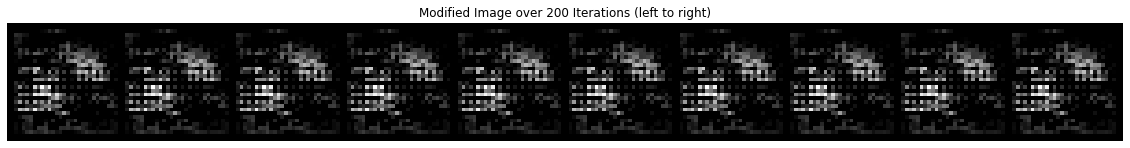

In [246]:
train_to_target(trained_cnn_with_garbage)

iteration: 20.......P(in target class): 0.219142.......Loss: 1.566270
iteration: 40.......P(in target class): 0.220038.......Loss: 1.564129
iteration: 60.......P(in target class): 0.219904.......Loss: 1.563889
iteration: 80.......P(in target class): 0.219917.......Loss: 1.563879
iteration: 100.......P(in target class): 0.220049.......Loss: 1.563841
iteration: 120.......P(in target class): 0.220002.......Loss: 1.563920
iteration: 140.......P(in target class): 0.219926.......Loss: 1.563909
iteration: 160.......P(in target class): 0.219980.......Loss: 1.563886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 180.......P(in target class): 0.219923.......Loss: 1.563934
iteration: 200.......P(in target class): 0.220047.......Loss: 1.563880
Maximum pixel value:  tensor(0.0316, device='cuda:0')


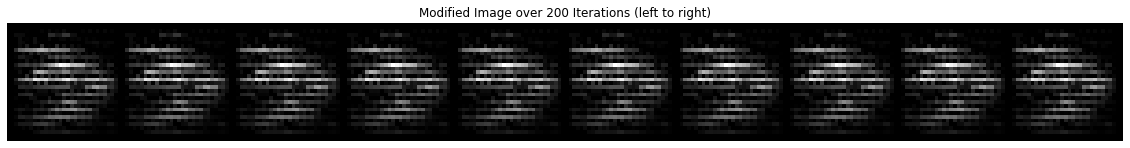

In [247]:
train_to_target(trained_cnn, 1)

iteration: 20.......P(in target class): 0.090690.......Loss: 2.497615
iteration: 40.......P(in target class): 0.090805.......Loss: 2.494042
iteration: 60.......P(in target class): 0.090734.......Loss: 2.493668
iteration: 80.......P(in target class): 0.090814.......Loss: 2.493713
iteration: 100.......P(in target class): 0.090811.......Loss: 2.493793
iteration: 120.......P(in target class): 0.090833.......Loss: 2.493615
iteration: 140.......P(in target class): 0.090792.......Loss: 2.493587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 160.......P(in target class): 0.090822.......Loss: 2.493795
iteration: 180.......P(in target class): 0.090768.......Loss: 2.493709
iteration: 200.......P(in target class): 0.090671.......Loss: 2.493879
Maximum pixel value:  tensor(0.0549, device='cuda:0')


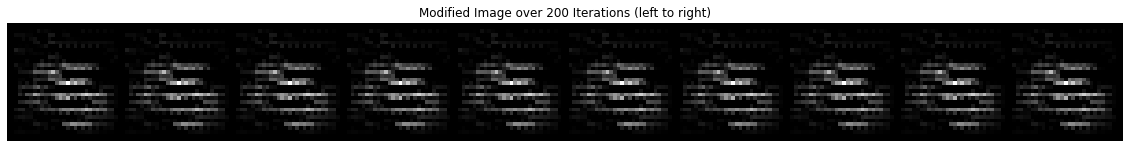

In [248]:
train_to_target(trained_cnn, 8)

iteration: 20.......P(in target class): 0.090834.......Loss: 2.495090
iteration: 40.......P(in target class): 0.090820.......Loss: 2.491990
iteration: 60.......P(in target class): 0.091098.......Loss: 2.491429
iteration: 80.......P(in target class): 0.091104.......Loss: 2.491397
iteration: 100.......P(in target class): 0.090927.......Loss: 2.491438
iteration: 120.......P(in target class): 0.091149.......Loss: 2.491571
iteration: 140.......P(in target class): 0.091111.......Loss: 2.491435
iteration: 160.......P(in target class): 0.090944.......Loss: 2.491485
iteration: 180.......P(in target class): 0.091094.......Loss: 2.491658
iteration: 200.......P(in target class): 0.091014.......Loss: 2.491336
Maximum pixel value:  tensor(0.0556, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


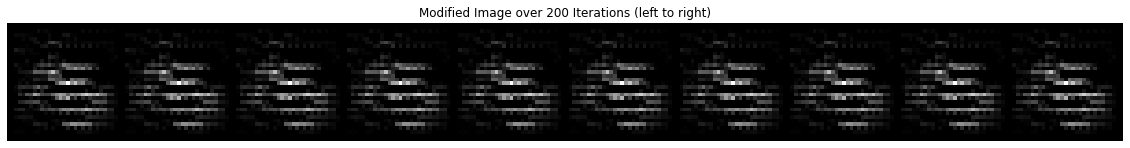

In [249]:
train_to_target(trained_cnn, 9)

## Takeaways

I think both CNNs performed worse. One observation is that the gradients in the CNNs do not make changes in individual pixels, but rather groups of pixels at a time, which kind of makes sense given how information propogates forward in kernels for the CNNs. 